In [20]:
import pandas as pd
import numpy as np
import model.pandas as mpd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
parking_meters = pd.read_csv('../data/parkingrecords.csv')
raw_train_data = pd.read_csv('../data/train-parking.csv')
intersection_locations = pd.read_csv('../intersection_locations2.csv').set_index(['Street1', 'Street2'])

In [3]:
good_tos = pd.read_feather('../good_tos.feather')

In [4]:
parking_meters['date'] = pd.to_datetime(parking_meters['datetime'], unit='ms')
parking_meters['month'] = parking_meters['date'].dt.month
parking_meters['year'] = parking_meters['date'].dt.year
parking_meters['hour'] = parking_meters['date'].dt.hour

In [5]:
parking_meters = parking_meters[(parking_meters['month'] == 3) & (parking_meters['year'] == 2015)]

In [6]:
raw_train_data[(raw_train_data['Street'] == raw_train_data['To']) | 
               (raw_train_data['Street'] == raw_train_data['From'])][['Street', 'From', 'To', 'Street.Length']].drop_duplicates()

,Street,From,To,Street.Length
9,Van Ness Avenue,Van Ness Avenue,Bush Street,39.027992
10,Larkin Street,Sutter Street,Larkin Street,48.555763
83,Kearny Street,Kearny Street,Post Street,52.369446
88,Post Street,Kearny Street,Post Street,104.362960
184,Van Ness Avenue,Van Ness Avenue,Eddy Street,52.744270
186,Van Ness Avenue,Van Ness Avenue,Turk Street,52.836143
192,Van Ness Avenue,Van Ness Avenue,Grove Street,52.045720
194,Van Ness Avenue,McAllister Street,Van Ness Avenue,154.604970
196,Van Ness Avenue,Van Ness Avenue,Grove Street,43.249866
197,Van Ness Avenue,Van Ness Avenue,Fell Street,40.671550


['Vas Ness Ave', 'Vas Ness Ave' (Austin), 'Bush'] 37.788982, -122.421987
['Larkin', 'Sutter', 'Larkin' (Fern)]   37.788428, -122.418594
['Kearny Street', 'Kearny Street', 'Post Street' (Some Alley)] 37.788446, -122.403611
['Post Street', 'Kearny Street', 'Post Street' (Some mall entrance)] 37.788805, -122.404416
['Van Ness Avenue', 'Van Ness Avenue' (Larch) , 'Eddy Street'] 37.782434679461765, -122.4208387018524

['Jones', 'Sutter', 'Jones'(cosmo)] 37.787941319325064,-122.4134360539673
['Mason Street', 'Sutter Street', 'Mason Street'(Some random split)] 37.7886079476511,-122.41018202640248

In [7]:
dists = cdist(intersection_locations.values, parking_meters[['lat', 'lon']].values, metric='euclidean')

In [8]:
closest_intersection = np.argmin(dists, axis = 0)

In [9]:
dists.shape

(279, 1758910)

In [17]:
closest_dists = dists[closest_intersection, np.arange(0, dists.shape[1])]

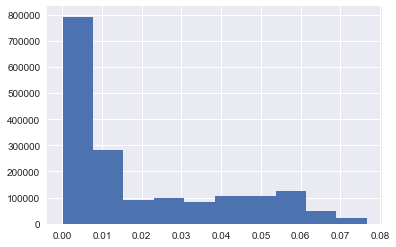

In [21]:
_ = plt.hist(closest_dists)

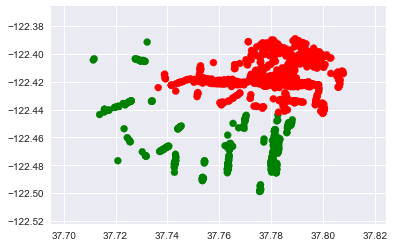

In [24]:
msk = np.random.randint(0, parking_meters.shape[0], size=1000)
plt.scatter(parking_meters['lat'].iloc[msk], parking_meters['lon'].iloc[msk], c = np.where((closest_dists < 0.02)[msk], 'r', 'g'))

In [25]:
parking_meters['closest_intersection_id'] = closest_intersection

In [26]:
closest_meters = parking_meters[closest_dists < 0.02]

In [35]:
x1 = closest_meters.groupby(['closest_intersection_id', 'hour'])['lat'].count().rename('meter_count')
x2 = closest_meters.groupby(['closest_intersection_id'])['lat'].count().rename('meter_count_intersection')
x3 = x1 / x2

In [64]:
meter_table = pd.DataFrame({'Street' : intersection_locations\
                              .reset_index()\
                              .iloc[x3.reset_index()['closest_intersection_id']]['Street1']\
                              .values,
               'From' : intersection_locations\
                          .reset_index()\
                          .iloc[x3.reset_index()['closest_intersection_id']]['Street2']\
                          .values,
               'hour' : x3.reset_index()['hour'].values,
               'percent_num' : x3.values}).set_index(['Street', 'From', 'hour'])

In [53]:
def dateDecoder(date_col):
    d1 = mpd.columnMapper(lambda x: x.dt.dayofweek, date_col, 'dow')
    d2 = mpd.columnMapper(lambda x: x.dt.month, date_col, 'month')
    
    return mpd.pipeline([d1, d2])

def timeDecoder(time_col):
    t1 = mpd.columnMapper(lambda x: x.str.extract('([0-9]+):[0-9]+', expand = False).astype('int'),
                     time_col, 'hour')
    t2 = mpd.columnMapper(lambda x: x.str.extract('[0-9]+:([0-9]+)', expand = False).astype('int'),
                     time_col, 'minute')
    
    return t1

In [70]:
outlier_removal = mpd.trainOnly(lambda df: df[(df['Real.Spots'] < 30) & (df['Street'] != 'Redwood Street')])
de = dateDecoder('Date')
te = timeDecoder('Time')
le = mpd.labelEncoder(['Street', 'From', 'To'])
add_latlng = mpd.MapE(lambda df: df.join(meter_table, on = ['Street', 'From', 'hour'], how = 'left'))

final_pipe = mpd.pipeline([outlier_removal, de, te, add_latlng, le])

In [71]:
raw_train_data['Date'] = pd.to_datetime(raw_train_data['Date'])

In [72]:
t, train2 = final_pipe.fit_transform(raw_train_data)

In [73]:
train2

,Date,Time,Real.Spots,Street.Length,any_spot,dow,month,hour,percent_num,Street,From,To
0,2014-01-07,16:19,4,179.132970,1,1,1,16,NaN,0,0,0
1,2014-01-18,20:42,0,52.740210,0,5,1,20,NaN,1,1,1
2,2014-01-18,20:39,0,52.517840,0,5,1,20,NaN,2,2,2
3,2014-01-18,20:38,0,52.405315,0,5,1,20,NaN,2,3,3
4,2014-01-18,20:38,0,52.191193,0,5,1,20,NaN,2,4,4
5,2014-01-18,20:20,0,52.324250,0,5,1,20,NaN,3,5,4
6,2014-01-18,20:21,0,146.416550,0,5,1,20,NaN,4,6,5
7,2014-01-18,20:22,0,139.494200,0,5,1,20,0.000385,4,7,6
8,2014-01-18,20:20,0,52.188343,0,5,1,20,NaN,3,8,7
9,2014-01-18,20:37,0,39.027992,0,5,1,20,NaN,2,9,8
